In [1]:
# import torch functions
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

# import torchvision functions
import torchvision
from torchvision.models import vgg16
import torchvision.utils as vutils
from torchvision import datasets, transforms, utils
import torchvision.transforms as T

# import other functions
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from itertools import islice
from PIL import Image
import time 
import torchsummary

In [2]:
original_dataset_dir = r'C:\Users\pattal\Documents\DamageDetection'

In [3]:
train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [4]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [5]:
# fonction pour entrainer les modeles

def fit(model, train_loader, val_loader, epochs, steps_per_epoch, validation_steps):
    epoch_nums = []
    training_acc = []
    validation_acc = []
    training_loss = []
    validation_loss = []
    
    for epoch in range(epochs):
        accuracy = 0.0
        running_loss = 0.0
        start_time = time.time()
        # Entraîne le modèle sur les données d'entraînement
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Entraîne le modèle sur un lot de données
            outputs = model(images)
            loss = criterion(outputs, labels.float().view(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #running_loss += loss.item()
            accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
            running_loss += loss.item()
        
            if (i+1) % steps_per_epoch == 0:
                break
        train_loss = running_loss / steps_per_epoch
        train_acc = accuracy / steps_per_epoch 
                
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for i, (images, labels) in enumerate(val_loader):
                outputs = model(images)
                val_loss += criterion(outputs, labels.float().view(-1,1)).item()
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
                
                if i >= validation_steps:
                    break
        
        val_loss /= validation_steps
        val_acc /= validation_steps 

        epoch_nums.append(epoch+1)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        
        elapsed_time = time.time() - start_time
        print(elapsed_time)
        print(f"Epoch [{epoch+1}/{epochs}], Time : {elapsed_time:.4f}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
    return {
        'training_acc': training_acc,
        'validation_acc': validation_acc,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
tomnod_1_50epochs = CNN()  
model = CNN()

In [7]:
torchsummary.summary(tomnod_1_50epochs, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
           Linear-10                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.53
Params size (MB): 13.17
Estim

In [8]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(tomnod_1_50epochs.parameters(), lr=0.0001)

In [9]:
datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0,), (1/255,))
])

train_dataset = ImageFolder(r'C:\Users\pattal\Documents\DamageDetection\train_another', transform=datagen)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = ImageFolder(r'C:\Users\pattal\Documents\DamageDetection\validation_another', transform=datagen)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)


In [10]:
print('Found {} images belonging to {} classes.'.format(len(train_dataset), len(train_dataset.classes)))
print('Found {} images belonging to {} classes.'.format(len(val_dataset), len(val_dataset.classes)))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 50
validation_steps = 50

# Lancer l'entraînement
history = fit(tomnod_1_50epochs, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

104.54944634437561
Epoch [1/20], Time : 104.5494, Train Loss: 0.3412, Train Accuracy: 0.6950, Validation Loss: 0.3862, Validation Accuracy: 0.8560
103.89802384376526
Epoch [2/20], Time : 103.8980, Train Loss: 0.2456, Train Accuracy: 0.8440, Validation Loss: 0.3030, Validation Accuracy: 0.8940
103.88396787643433
Epoch [3/20], Time : 103.8840, Train Loss: 0.0635, Train Accuracy: 0.8845, Validation Loss: 0.2454, Validation Accuracy: 0.9180
102.80270886421204
Epoch [4/20], Time : 102.8027, Train Loss: 0.2213, Train Accuracy: 0.9010, Validation Loss: 0.2027, Validation Accuracy: 0.9350
101.66180658340454
Epoch [5/20], Time : 101.6618, Train Loss: 0.3690, Train Accuracy: 0.8990, Validation Loss: 0.1991, Validation Accuracy: 0.9340
101.07002139091492
Epoch [6/20], Time : 101.0700, Train Loss: 0.1663, Train Accuracy: 0.9080, Validation Loss: 0.2325, Validation Accuracy: 0.9210
106.72741222381592
Epoch [7/20], Time : 106.7274, Train Loss: 0.3060, Train Accuracy: 0.9240, Validation Loss: 0.4409,

KeyboardInterrupt: 

In [73]:
path_save=r"C:\Users\pauli\Documents\M2\ML et DL\projet\Git"
torch.save(tomnod_1_50epochs.state_dict(), path_save+"/tomnod_1_50epochs.pth")

#tomnod_1_50epochs = CNN()
#tomnod_1_50epochs.load_state_dict(torch.load(path_save+"tomnod_1_50epochs.pth"))
#torchsummary.summary(tomnod_1_50epochs, (3,150,150))

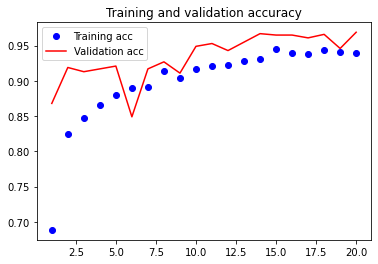

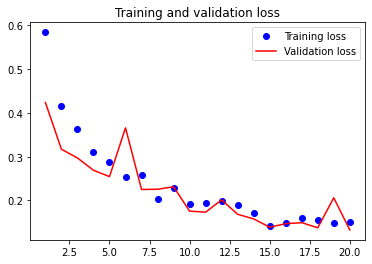

In [27]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        x = self.dropout(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
tomnod_2_100epochs = CNN2()

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(tomnod_1_50epochs.parameters(), lr=0.0001)

In [ ]:
train_datagen  = transforms.Compose([
    transforms.Resize((150, 150)), #transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0,), (1/255,)),
    transforms.RandomRotation(40),
    transforms.RandomCrop(0.2),
    transforms.RandomResizedCrop(0.2),
    transforms.RandomHorizontalFlip()
    #transforms.Normalize((0,), (1/255,))
])

test_datagen = transforms.Compose([
    transforms.Resize((150, 150)), #transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0,), (1/255,)),
])


train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=test_datagen)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 100
validation_steps = 50

# Lancer l'entraînement
history = fit(tomnod_2_100epochs, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

In [ ]:
path_save=r"C:\Users\pauli\Documents\M2\ML et DL\projet\Git"
torch.save(tomnod_2_100epochs.state_dict(), path_save+"/tomnod_2_100epochs.pth")

#tomnod_2_100epochs = CNN2()
#tomnod_2_100epochs.load_state_dict(torch.load(path_save+"tomnod_2_100epochs.pth"))
#torchsummary.summary(tomnod_2_100epochs, (3,150,150))

In [ ]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Adam optimizer

In [ ]:
tomnod_2_100epochs_Adam = CNN2()

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(tomnod_2_100epochs_Adam.parameters(), lr=0.0001)

In [ ]:
train_datagen  = transforms.Compose([
    transforms.Resize((150, 150)), #transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0,), (1/255,)),
    transforms.RandomRotation(40),
    transforms.RandomCrop(0.2),
    transforms.RandomResizedCrop(0.2),
    transforms.RandomHorizontalFlip()
    #transforms.Normalize((0,), (1/255,))
])

test_datagen = transforms.Compose([
    transforms.Resize((150, 150)), #transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0,), (1/255,)),
])


train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=test_datagen)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 100
validation_steps = 50

# Lancer l'entraînement
history = fit(tomnod_2_100epochs_Adam, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

In [ ]:
path_save=r"C:\Users\pauli\Documents\M2\ML et DL\projet\Git"
torch.save(tomnod_2_100epochs_Adam.state_dict(), path_save+"/tomnod_2_100epochs_Adam.pth")

#tomnod_2_100epochs_Adam = CNN2()
#tomnod_2_100epochs_Adam.load_state_dict(torch.load(path_save+"/tomnod_2_100epochs_Adam.pth"))
#torchsummary.summary(tomnod_2_100epochs_Adam, (3,150,150))

In [ ]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
img_path = r'C:\Users\pattal\Documents\DamageDetection\damage\-96.960704_28.783292.jpeg'

img = Image.open(img_path)
img = img.resize((150,150))
img_tensor = np.array(img)
img_tensor = img_tensor.transpose((2, 0, 1))
img_tensor = img_tensor[np.newaxis, :]
img_tensor = img_tensor.astype('float32') / 255.

print(img_tensor.shape)

(1, 3, 150, 150)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


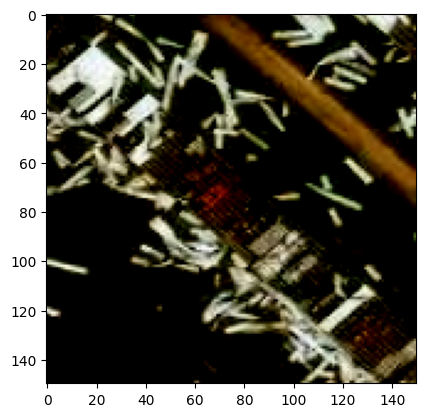

In [10]:
transform = T.Compose([
    T.Resize((150, 150)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0)

# visualizing the tensor
plt.imshow(img_tensor[0].permute(1, 2, 0))
plt.show()


In [11]:
def get_activations(model, input_data):
    activations = []
    activations.append(input_data)
    for i, layer in enumerate(model):
        activations.append(layer(activations[i]))
    return activations

In [16]:
layer_outputs = []
layer_names = []
# Boucle sur les 8 premières couches du modèle
for i, module in enumerate(list(model.children())[:8]):
    layer_outputs.append(module)
    layer_names.append(f"Layer {i}")

# Appeler la fonction pour obtenir les activations des 8 premières couches
activations = get_activations(layer_outputs, img_tensor)

# Définir le nombre d'images par ligne
images_per_row = 16


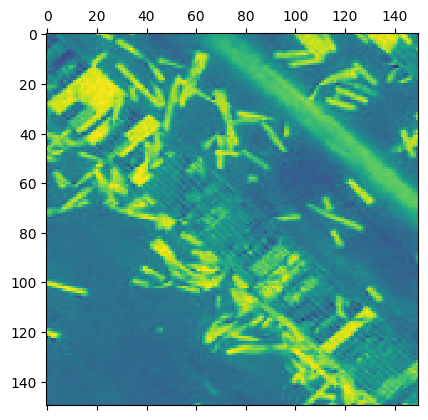

In [17]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0][0, :, :], cmap='viridis')


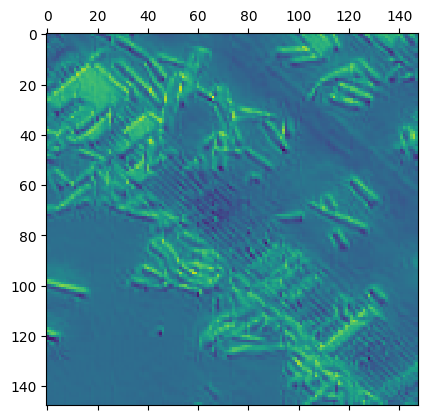

In [18]:
second_layer_activation = activations[1]
plt.matshow(second_layer_activation[0][0, :, :].detach().numpy(),cmap = 'viridis')


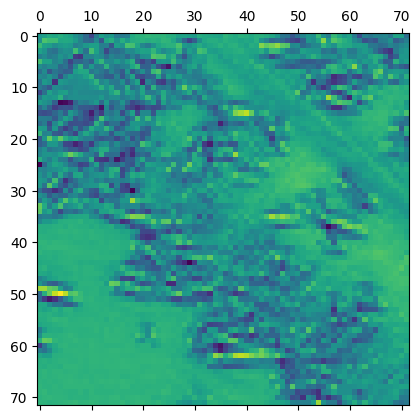

In [19]:
third_layer_activation = activations[3]
plt.matshow(third_layer_activation[0][0, :, :].detach().numpy(), cmap='viridis')


C:\Users\pattal\AppData\Local\Temp\ipykernel_8268\2449567393.py:23: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
C:\Users\pattal\.conda\envs\DL\lib\site-packages\matplotlib\_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
C:\Users\pattal\.conda\envs\DL\lib\site-packages\matplotlib\_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
C:\Users\pattal\.conda\envs\DL\lib\site-packages\matplotlib\patches.py:737: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
C:\Users\pattal\.conda\envs\DL\lib\site-packages\matplotlib\transforms.py:2047: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty


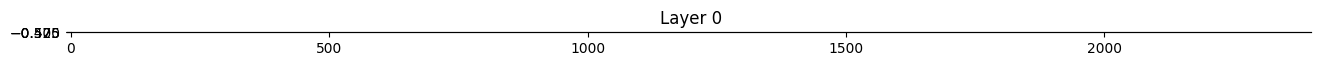

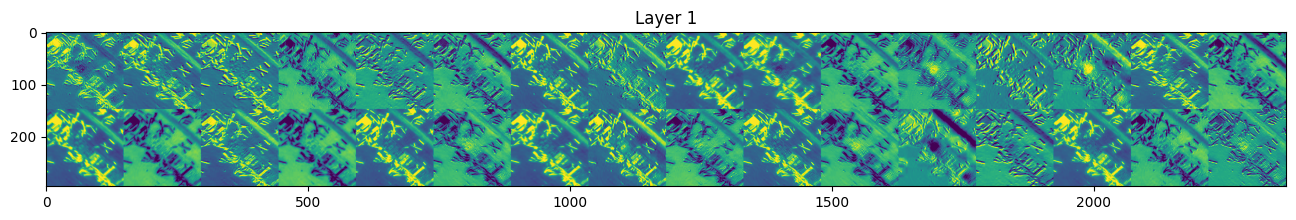

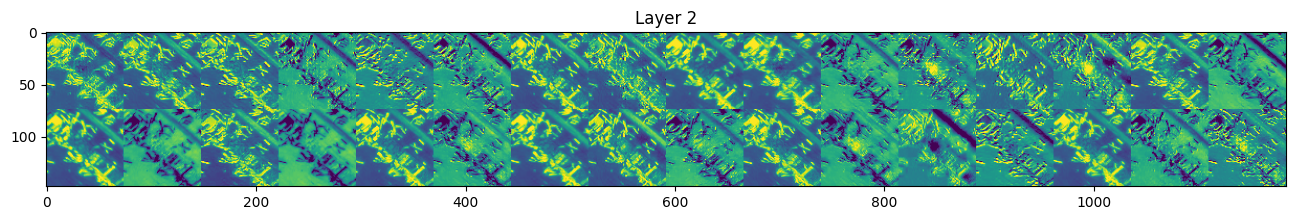

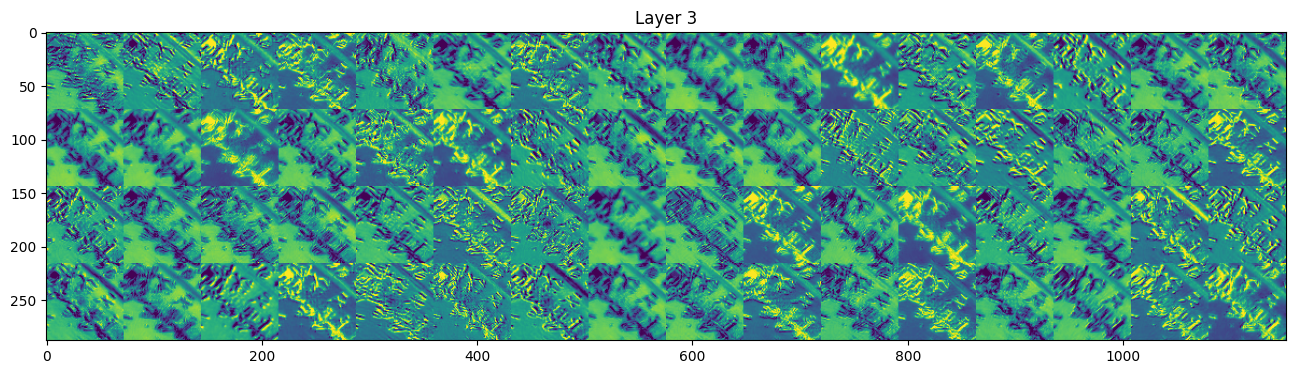

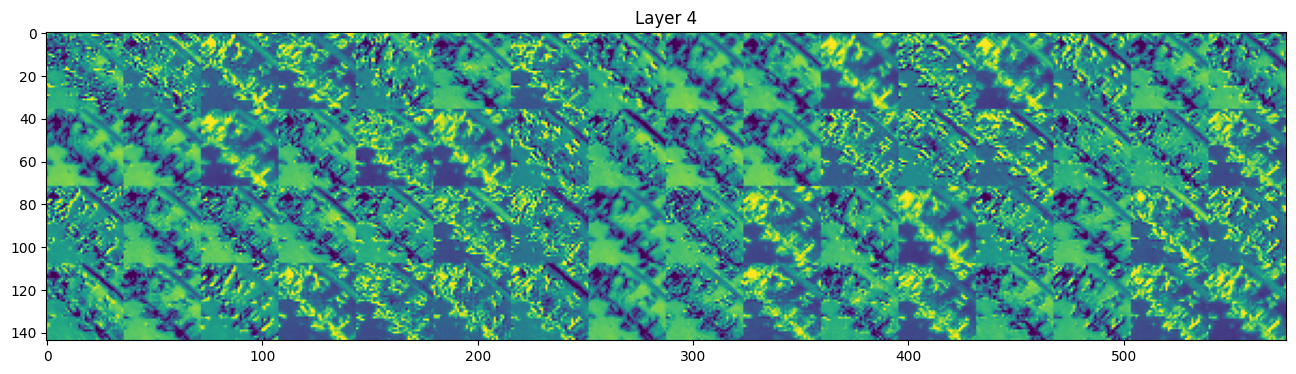

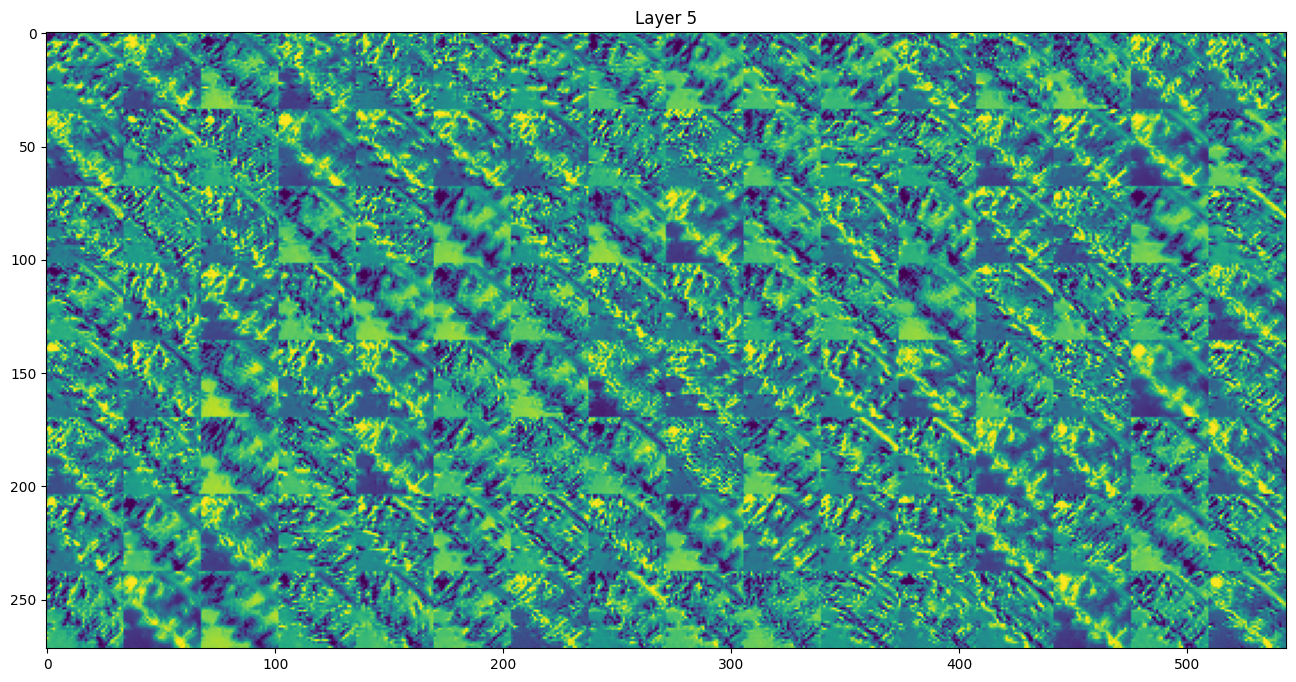

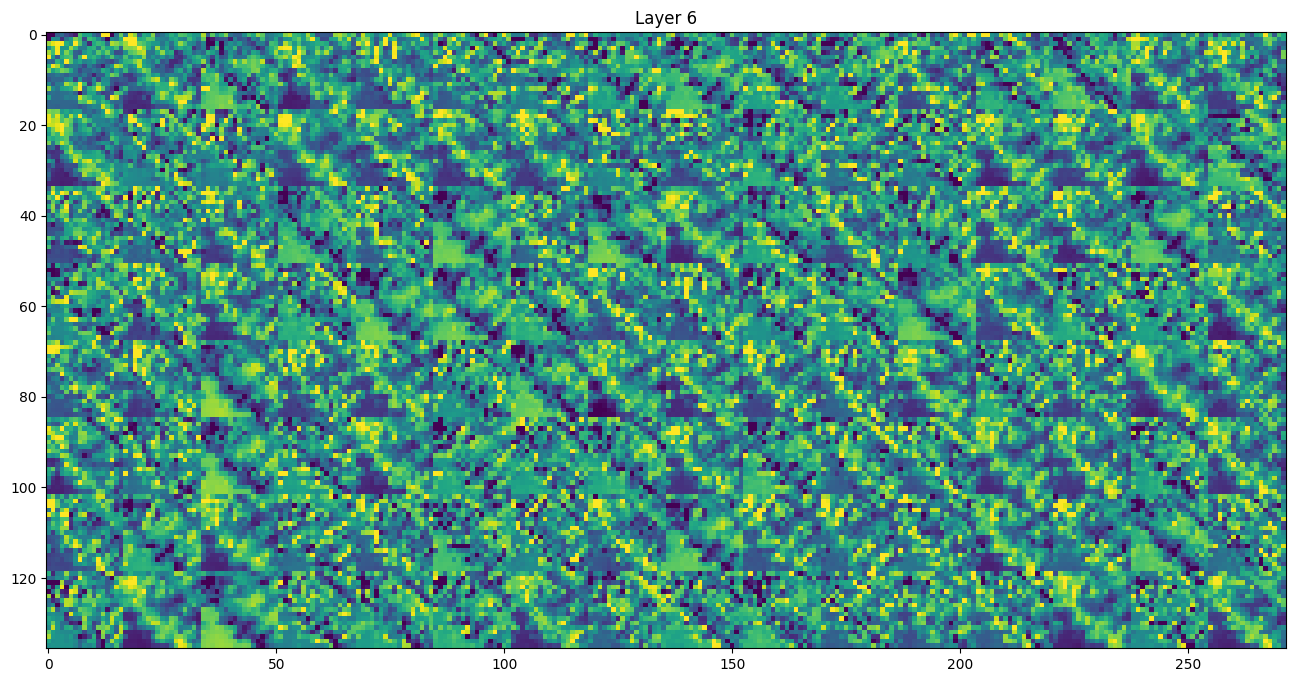

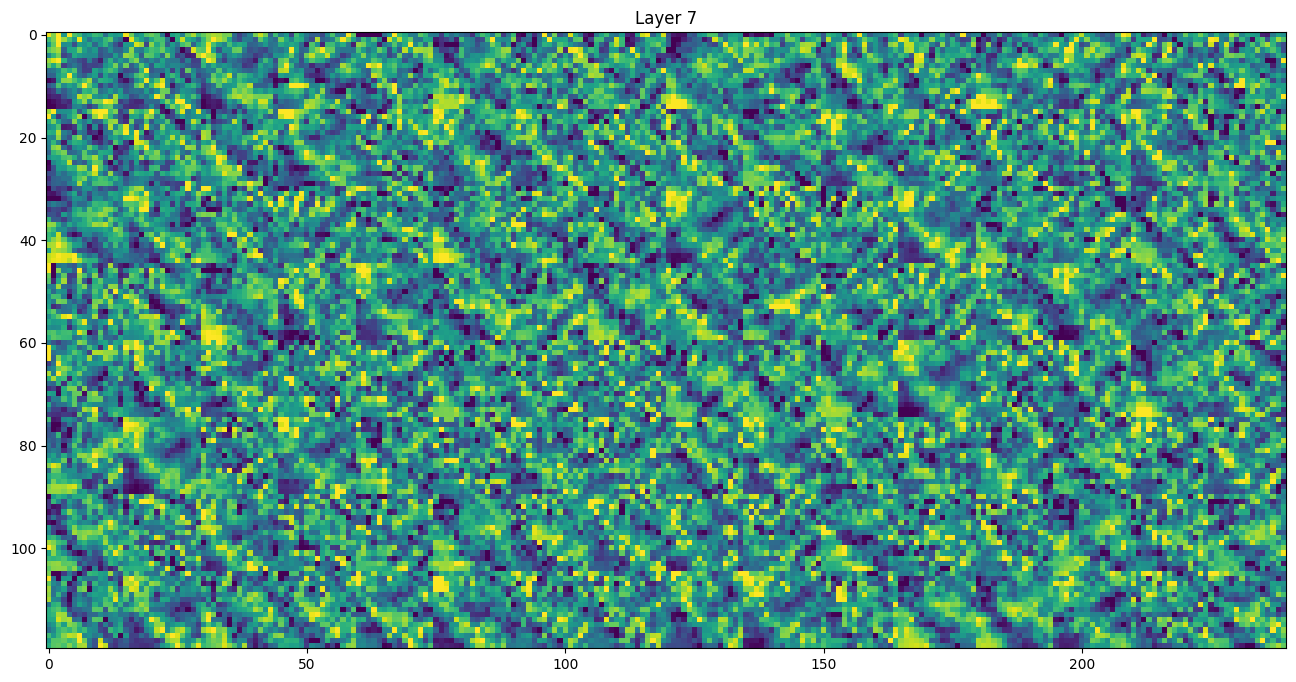

In [20]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[1]
    size = layer_activation.shape[2]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size))
    layer_activation = layer_activation.detach().numpy()
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, col*images_per_row + row, :, :]
            #channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

In [12]:
# Chargment du modèle pré-entraîné ResNet18
modelvgg16 = torchvision.models.vgg16(pretrained=True)
torchsummary.summary(modelvgg16, (3,150,150))

# Extraction des caractéristiques
modelvgg16 = modelvgg16.features[:-1] # nombre de caractéristiques en entrée de la couche fc
torchsummary.summary(modelvgg16, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [13]:

datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize((0,), (1/255,))
])

batch_size=20

train_dataset = ImageFolder(r'C:\Users\pattal\Documents\DamageDetection\train_another', transform=datagen)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

val_dataset = ImageFolder(r'C:\Users\pattal\Documents\DamageDetection\validation_another', transform=datagen)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

test_dataset = ImageFolder(r'C:\Users\pattal\Documents\DamageDetection\test_another', transform=datagen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=True)


modelvgg16.eval()

# Extraire les caractéristiques des images
def extract_features(data_loader, sample_count, conv_base, batch_size):
    features = torch.zeros(sample_count, 512, 9, 9)
    labels = torch.zeros(sample_count, dtype=torch.long)
    
    i = 0
    for inputs_batch, labels_batch in data_loader:
        with torch.no_grad():
            features_batch = conv_base(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


In [14]:
train_features, train_labels = extract_features(train_loader, 10000, modelvgg16, batch_size=batch_size)
validation_features, validation_labels = extract_features(val_loader, 2000, modelvgg16, batch_size=batch_size)
test_features, test_labels = extract_features(test_loader, 2000, modelvgg16, batch_size=batch_size)

# Reformater les caractéristiques pour être de forme (sample_count, 8192)
train_features = train_features.view(10000, 9 * 9 * 512)
validation_features = validation_features.view(2000, 9 * 9 * 512)
test_features = test_features.view(2000, 9 * 9 * 512)

In [28]:
def train(BinaryClassifier, train_features, train_labels, val_features, validation_labels, num_epochs, batch_size):
    train_features = train_features.float()
    train_labels = train_labels.long()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # Valider le modèle
        with torch.no_grad():
            validation_outputs = model(validation_features.float())
            _, validation_predicted = torch.max(validation_outputs, 1)
            validation_correct = (validation_predicted == validation_labels.long()).sum().item()
            validation_accuracy = validation_correct / validation_labels.shape[0]
            print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, loss.item(), validation_accuracy * 100))
        
        
def evaluate(model, test_feature, test_labels):
    with torch.no_grad():
        test_outputs = model(test_features.float())
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct = (test_predicted == test_labels.long()).sum().item()
        test_accuracy = test_correct / test_labels.shape[0]
        print('Test Accuracy: {:.2f}%'.format(test_accuracy * 100))




In [29]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(4*4*512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x
BinaryClassifier = BinaryClassifier()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

train(BinaryClassifier, train_features, train_labels, validation_features, validation_labels, 10, 20)

#BinaryClassifier.evaluate(test_features,test_labels)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x41472 and 8192x256)

In [ ]:
# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 30
validation_steps = 50

# Lancer l'entraînement
history = fit(BinaryClassifier, train_features, validation_features, epochs, steps_per_epoch, validation_steps)

In [15]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(C = 1)
logisticRegr.fit(train_features,train_labels)
#balanced test set 
score1 = logisticRegr.score(validation_features, validation_labels)
print("Validation acc = ", score1)

C:\Users\pattal\.conda\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation acc =  0.9365


In [35]:
# Chargement du modèle
model_load = model

# Évaluation du modèle
with torch.no_grad():
    test_outputs = model_load(test_features)
    test_loss = nn.BCELoss()(test_outputs, test_labels)
    test_results = (test_loss, test_outputs.argmax(dim=1).eq(test_labels).float().mean().item())
    print(test_results)


class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size, C=1):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.C = C

    def forward(self, x):
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x




NameError: name 'test_features' is not defined